# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante:

Base de dados:

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error


from tqdm.notebook import tqdm
from google.colab import drive 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y


In [ ]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [ ]:
#path = '/content/drive/MyDrive/Topicos_A/Previsao/microclima5/microclima5.csv'
path = '/content/microclima6.csv'
raw_data = pd.read_csv(path)


## Compreensão do problema

1)	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

In [ ]:
raw_data

,value,time
0,33.720968,1.0
1,34.723214,2.0
2,33.084274,3.0
3,30.005000,4.0
4,25.253629,5.0
...,...,...
139,23.990323,8.0
140,25.755417,9.0
141,23.843145,10.0
142,31.638750,11.0


2)	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

## Previsão one-step

1)	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

In [ ]:
train_val ,test_val = transform_data(raw_data,lag=12,test_split = 12,normalize=True,category='numeric')




In [ ]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.915141,1.000000,0.861233,0.600514,0.198221,0.146195,0.075622,0.175722,0.208744,0.150629,0.184755,0.680731,0.844436,0.935629
1,0.181818,1.000000,0.861233,0.600514,0.198221,0.146195,0.075622,0.175722,0.208744,0.150629,0.184755,0.680731,0.844436,0.935629,0.704766
2,0.272727,0.861233,0.600514,0.198221,0.146195,0.075622,0.175722,0.208744,0.150629,0.184755,0.680731,0.844436,0.935629,0.704766,0.369827
3,0.363636,0.600514,0.198221,0.146195,0.075622,0.175722,0.208744,0.150629,0.184755,0.680731,0.844436,0.935629,0.704766,0.369827,0.188627
4,0.454545,0.198221,0.146195,0.075622,0.175722,0.208744,0.150629,0.184755,0.680731,0.844436,0.935629,0.704766,0.369827,0.188627,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.201020,0.159915,0.245787,0.313582,0.341427,0.490977,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341
115,0.727273,0.159915,0.245787,0.313582,0.341427,0.490977,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814
116,0.818182,0.245787,0.313582,0.341427,0.490977,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989
117,0.909091,0.313582,0.341427,0.490977,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324


In [ ]:
test_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.490977,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345
1,0.090909,0.545705,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483
2,0.181818,0.595857,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236
3,0.272727,0.577933,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302
4,0.363636,0.485329,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818
5,0.454545,0.231815,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818,0.081635
6,0.545455,0.136529,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818,0.081635,0.020928
7,0.636364,0.113245,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818,0.081635,0.020928,0.091258
8,0.727273,0.093341,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818,0.081635,0.020928,0.091258,0.240707
9,0.818182,0.075814,0.210989,0.092324,0.260050,0.626345,0.779483,0.606236,0.331302,0.303818,0.081635,0.020928,0.091258,0.240707,0.078797


In [ ]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [ ]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 10

In [ ]:
def train(model, train_loader, epochs, device, lr):

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  history = {'loss_train': []}

  for e in tqdm(range(1, epochs+1)):
    
    y_hat = np.array([])

    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X, y = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        y_p = torch.argmax(y_pred, dim=1)
        y_hat = np.concatenate((y_hat, y_p))
    
    #_, val_loss, val_acc = evaluate(model, val_loader, criterion, device, binary=binary)

    history['loss_train'].append(train_epoch_loss)
    
    print(f'Epoch {e+0:03} | Train Loss: {train_epoch_loss/len(train_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss/len(val_loader):.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc/len(val_loader):.4f}')
  return history, y_hat


In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.01
epochs = 1500

history, y_hat = train(model, train_loader, epochs, device, lr)

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.061
Epoch 002 | Train Loss: 0.059
Epoch 003 | Train Loss: 0.057
Epoch 004 | Train Loss: 0.056
Epoch 005 | Train Loss: 0.055
Epoch 006 | Train Loss: 0.054
Epoch 007 | Train Loss: 0.053
Epoch 008 | Train Loss: 0.052
Epoch 009 | Train Loss: 0.052
Epoch 010 | Train Loss: 0.051
Epoch 011 | Train Loss: 0.051
Epoch 012 | Train Loss: 0.050
Epoch 013 | Train Loss: 0.050
Epoch 014 | Train Loss: 0.050
Epoch 015 | Train Loss: 0.049
Epoch 016 | Train Loss: 0.049
Epoch 017 | Train Loss: 0.049
Epoch 018 | Train Loss: 0.049
Epoch 019 | Train Loss: 0.048
Epoch 020 | Train Loss: 0.048
Epoch 021 | Train Loss: 0.048
Epoch 022 | Train Loss: 0.048
Epoch 023 | Train Loss: 0.048
Epoch 024 | Train Loss: 0.048
Epoch 025 | Train Loss: 0.047
Epoch 026 | Train Loss: 0.047
Epoch 027 | Train Loss: 0.047
Epoch 028 | Train Loss: 0.047
Epoch 029 | Train Loss: 0.047
Epoch 030 | Train Loss: 0.046
Epoch 031 | Train Loss: 0.046
Epoch 032 | Train Loss: 0.046
Epoch 033 | Train Loss: 0.046
Epoch 034 

In [ ]:
y_pred = model(torch.from_numpy(X_train).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 1.433 
Erro MAE = 0.968


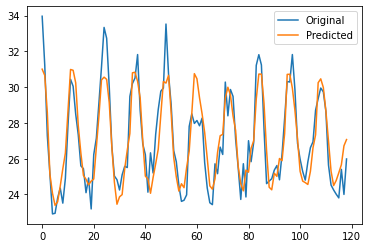

In [ ]:
orig_y_eval = y_train*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


2)	Modifique a técnica de codificação mensal de ‘numérico’ para ‘binário’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

## Previsão multi-step

1)	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 

In [ ]:
y_hat

tensor([0.5515], grad_fn=<AddBackward0>)

In [ ]:
cod = 'numeric'    #Escolha da codificação da variável mês

y_result = []
X_t = np.copy(X_test[0])
for i in range(12):
    y_hat = model(torch.from_numpy(X_t).float())
    
    if cod == 'numeric':

      #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
      #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
      tmp = int(X_t[0] * 12 + 1) % 12
      
      #Alterando a variável mês
      X_t[0] = tmp/12
      
      #Movendo todos os registros, 'deslizando a janela'
      X_t[1:X_t.shape[0]-1] = X_t[2:]

    elif cod == 'binary':

      #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
      #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
      tmp = int(8*X_t[0] + 4*X_t[1] + 2*X_t[2] + 1*X_t[3] + 1) % 12
      
      #Mudamos novamente para a representação binária
      binary_rep = np.binary_repr(tmp,width=4)

      #Alterando a variável mês (4 primeiras variáveis)
      X_t[:4] = np.array([int(v) for v in binary_rep])

      #Movendo todos os registros, 'deslizando a janela'
      X_t[4:X_t.shape[0]-1] = X_t[5:]


    elif cod == '1ofN':
      pass

    else:
      print('Erro de codificação.')
      break
    

    X_t[-1] = y_hat
    
    y_result.append(y_hat[0].detach().numpy())


y_result = np.array(y_result)

tensor(0.5515, grad_fn=<SelectBackward0>)

Erro MSE = 5.924 
Erro MAE = 1.887


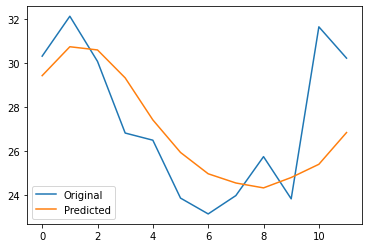

In [ ]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

2)	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

3)	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

4)	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.